#  Image Segmentation

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from matplotlib import patches
from IPython.display import clear_output


## Mouse Settings

In [6]:
    # Adding Function Attached To Mouse Callback
global imgTmp 
def drawLine(event,x,y,flags,params):
        global ixLineAdd,iyLineAdd,ixLineRemove, iyLineRemove, ix, iy, drawing, color, whichClick, imageHeight, imageWidth, lineAdd, lineRemove
        # Left Mouse Button Down Pressed
        if(event==1):
            drawing = True
            color = 255
            whichClick = 1
            ix = x
            iy = y
        # Right mouse button Down Pressed
        if(event==2):
            drawing = True
            color = 0
            whichClick = 2
            ix = x
            iy = y

        if(event==0):
            if(drawing==True):
                #For Drawing Line
                cv2.line(imgTmp,pt1=(ix,iy),pt2=(x,y),color=(color,color,color),thickness=3)
                ix = x
                iy = y
                if(whichClick == 1):
                    for i in range(0, 5):
                        if(((ix+i) < imageWidth) and ((ix-i) >= 0)):
                            #print(ix+i,i)
                            ixLineAdd.append(ix+i)
                        if(((iy+i) < imageHeight) and ((iy-i) >= 0)):    
                            iyLineAdd.append(iy+i)
                        if(((ix-i) >= 0) and ((ix+i) < imageWidth)):
                            ixLineAdd.append(ix-i)
                        if(((iy-i) >= 0) and ((iy+i) < imageHeight)):
                            iyLineAdd.append(iy-i)
                elif(whichClick==2):
                    for i in range(0, 5):
                        if(((ix+i) < imageWidth) and ((ix-i) >= 0)):
                            #print(ix+i,i)
                            ixLineRemove.append(ix+i)
                        if(((iy+i) < imageHeight) and ( (iy-i) >= 0)):
                            iyLineRemove.append(iy+i)
                        if(((ix-i) >= 0) and ((ix+i) < imageWidth)):
                            ixLineRemove.append(ix-i)
                        if(((iy-i) >= 0) and ((iy+i) < imageHeight)):
                            iyLineRemove.append(iy-i)
                        #print(ixLineRemove,i)
                    
        # Mouse button released
        if(event==4 or event==5):
            drawing = False
            if(len(iyLineAdd)>0 and len(ixLineAdd)>0):
                n = min(len(iyLineAdd), len(ixLineAdd))
                lineAdd = np.vstack((iyLineAdd[:n], ixLineAdd[:n])).T
                #iyLineAdd = np.unique(iyLineAdd, axis=0)
                #ixLineAdd = np.unique(ixLineAdd, axis=0)
            if(len(iyLineRemove)>0 and len(ixLineRemove)>0):
                n = min(len(iyLineRemove), len(ixLineRemove))
                lineRemove = np.vstack((iyLineRemove[:n], ixLineRemove[:n])).T
                #iyLineRemove = np.unique(iyLineRemove, axis=0)
                #ixLineRemove = np.unique(ixLineRemove, axis=0)
            
def drawRect(event,x,y,flags,params):
        global ix,iy,ix2,iy2,drawing
        # Left Mouse Button Down Pressed
        if(event==1):
            drawing = True
            ix = x
            iy = y
        # Mouse button released
        if(event==4):
            drawing = False
            cv2.rectangle(imgTmp,pt1=(ix,iy),pt2=(x,y),color=(255,255,255),thickness=3)
            ix2=x
            iy2=y

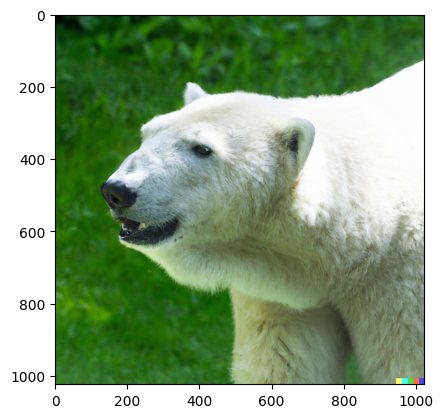

In [7]:
# Setup image and mask

#Insert your file name and extension here
fileName = 'p4.png'
img = cv2.imread(fileName)[:,:,::-1]
mask = np.zeros(img.shape[:2],np.uint8)

# GrabCut parameters
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
imageHeight = img.shape[:2][0]
imageWidth = img.shape[:2][1]

#Show image
figure, ax = plt.subplots(1)
ax.imshow(img)

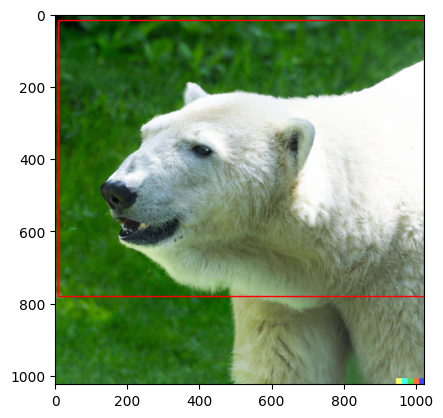

In [8]:
drawing = False
ix, iy, ix2, iy2 = -1, -1, -1, -1
imgTmp = img.copy()
originalImage = img.copy()
# Making Window For The Image
cv2.namedWindow("Select the foreground with a rectangle")

# Adding Mouse CallBack Event
cv2.setMouseCallback("Select the foreground with a rectangle",drawRect)

# Starting The Loop So Image Can Be Shown and allow exit on "Q" key pressed
while(True):
    cv2.imshow("Select the foreground with a rectangle",imgTmp)
    if cv2.waitKey(20) & 0xFF == ord('q'):
        break
cv2.destroyAllWindows()
figure, ax = plt.subplots(1)

# Rectangle info for foreground, conditions so the rectangle works in every way
if(ix2 <ix):
    ix2, ix = ix, ix2
if(iy2<iy):
    iy2, iy = iy, iy2
# Save the rectangle's information
width = abs(ix2-ix)
height = abs(iy2-iy)
xStart = ix
yStart = iy

# Show rectangle including foreground item on image
rect = patches.Rectangle((ix ,iy),width ,height , edgecolor='r', facecolor="none")
ax.imshow(img)
ax.add_patch(rect)
rect = (xStart,yStart,width,height)

## User marked result

In [ ]:
# Loop for the algorithm
counter = 0
while(True):
    
    # Variables used
    drawing = False
    ixLineAdd, iyLineAdd,ixLineRemove, iyLineRemove, ix, iy, whichClick = [], [],[], [], 0, 0, 0
    lineAdd = []
    lineRemove = []
    imgTmp = img.copy()
    color = 50
    
    # After the first iteration, replace the mask since it was converted from [0:3] to [0:1]
    if counter > 0:
        mask = maskTmp.copy()
        
    # Making Window For The Image
    cv2.namedWindow("Right click to remove and left click to add")
    # Adding Mouse CallBack Event
    cv2.setMouseCallback("Right click to remove and left click to add",drawLine)

    # Starting The Loop So Image Can Be Shown
    while(True):
        cv2.imshow("Right click to remove and left click to add",imgTmp)
        if cv2.waitKey(20) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()
    figure, ax = plt.subplots(1)
    
    # Edit the mask for the algorithm based on the user's inputs
    if len(lineAdd)>0:
        mask[lineAdd[:,0],lineAdd[:,1]] = 1
    if len(lineRemove)>0:
        mask[lineRemove[:,0],lineRemove[:,1]] = 0
        
    #Grabcut algorithm with template mask, save the mask before the grabcut changes it
    maskTmp = mask.copy()
    mask, bgdModel, fgdModel = cv2.grabCut(img,mask,None,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_MASK)
    mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img = originalImage*mask[:,:,np.newaxis]
    counter = counter + 1
    
    # Show final result and ask to continue the algorithm or not
    print("Final result: ")
    plt.imshow(img),plt.show()
    if input('Would you like to continue editing?\n') != 'y':
        break
    clear_output(wait=True)

## Self made function

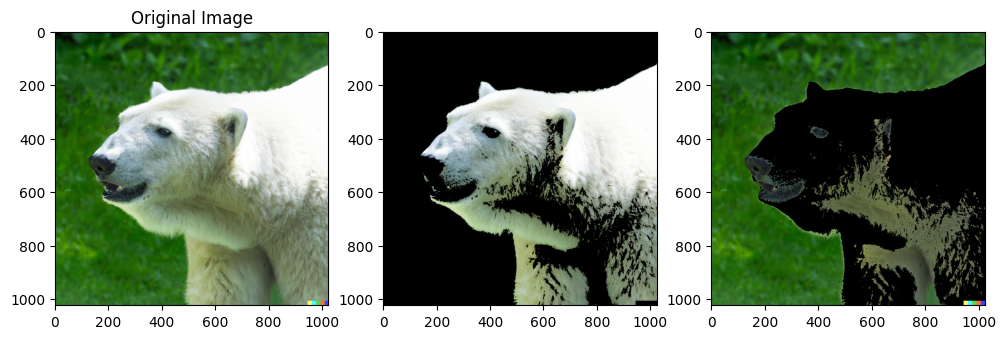

In [10]:
def initialize_gmm(img, mask):
    fg_pixels = img[mask == 1]
    bg_pixels = img[mask == 0]

    fg_mean = np.mean(fg_pixels, axis=0)
    bg_mean = np.mean(bg_pixels, axis=0)
     
    fg_cov = np.cov(fg_pixels.T)
    bg_cov = np.cov(bg_pixels.T)

    return fg_mean, bg_mean, fg_cov, bg_cov

def calculate_probability(pixel, mean, cov):
    d = pixel - mean
    exponent = -0.5 * np.dot(np.dot(d.T, np.linalg.inv(cov)), d)
    return (1.0 / (2 * np.pi * np.sqrt(np.linalg.det(cov)))) * np.exp(exponent)

def grabcut(img, mask, rect, iterations=5):
    fg_model, bg_model = np.zeros_like(img), np.zeros_like(img)

    x, y, w, h = rect
    mask[y:y+h, x:x+w] = 1
    
    for _ in range(iterations):
        fg_mean, bg_mean, fg_cov, bg_cov = initialize_gmm(img, mask)

        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                pixel = img[i, j]

                fg_prob = calculate_probability(pixel, fg_mean, fg_cov)
                bg_prob = calculate_probability(pixel, bg_mean, bg_cov)

                if fg_prob > bg_prob:
                    mask[i, j] = 1
                else:
                    mask[i, j] = 0

        fg_model = img * (mask[:, :, np.newaxis] == 1)
        bg_model = img * (mask[:, :, np.newaxis] == 0)

    return mask, fg_model, bg_model

# Example usage
img = cv2.imread('p4.png')
rect = (25, 25, width, height)  # Specify the rectangle coordinates
mask = np.zeros(img.shape[:2], dtype=np.uint8)

result_mask, fg_result, bg_result = grabcut(img, mask, rect, iterations=5)

# Display the results-
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.subplot(132)
plt.imshow(cv2.cvtColor(fg_result, cv2.COLOR_BGR2RGB))

plt.subplot(133)
plt.imshow(cv2.cvtColor(bg_result, cv2.COLOR_BGR2RGB))

plt.show()
